# Self-Driving Car Engineer Nanodegree


## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Helper Functions
Below are some helper functions to help get you started. They should look familiar from the lesson!


**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

In [51]:
import math
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt
%matplotlib inline

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    x_r = [];
    y_r = [];
    x_l = [];
    y_l = [];
    y_max = img.shape[0];
    y_min = 0;
    x_max = img.shape[1];
    x_min = 0;
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope > 0 and slope <1:
                x_r = x_r + [x1,x2]
                y_r = y_r + [y1,y2]
            elif slope < -0.6 and slope >-1:
                x_l = x_l + [x1,x2]
                y_l = y_l + [y1,y2]
    
    if len(x_r) == 0 | len(y_r) == 0:
        print('No right lane found')
    else:
        fit_r = np.polyfit(x_r,y_r,deg=1)
        print('fit_r is',fit_r)
        print('y_max-fit_r[1])/fit_r[0]',(y_max-fit_r[1])/fit_r[0])
        print('y_min-fit_r[1])/fit_r[0]',(y_min-fit_r[1])/fit_r[0])
        cv2.line(img, (math.ceil((y_max-fit_r[1])/fit_r[0]), y_max), \
                      (math.ceil((y_min-fit_r[1])/fit_r[0]), y_min), color, thickness)
    
    if len(x_l) == 0 | len(y_l) == 0:
        print('No left lane found')
    else:
        fit_l = np.polyfit(x_l,y_l,deg=1)
        cv2.line(img, (math.ceil((y_max-fit_l[1])/fit_l[0]), y_max),\
                      (math.ceil((y_min-fit_l[1])/fit_l[0]), y_min), color, thickness)
        
        
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)



def corners_unwarp(img, nx, ny, mtx, dist):
    """
    This function will conduct perspective transormation of a chessboard. 
    """
    #dst = cv2.undistort(img, mtx, dist)
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    # 2) Convert to grayscale
    gray = cv2.cvtColor(dst,cv2.COLOR_BGR2GRAY)
    gray = cv2.merge([gray,gray,gray])
    # 3) Find the chessboard corners
    retval, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    # print('corners are',corners)
    # 4) If corners found: 
            # a) draw corners
    if retval == True: 
        cv2.drawChessboardCorners(gray,(nx,ny),corners,retval)
        #plt.imshow(gray,cmap='gray')
    else: print('no corners fonund')
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code

    src = np.float32([corners[0][0],
                      corners[(nx-1)][0],
                      corners[-1][0],
                      corners[-nx][0]])

            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[100,100],
                      [850,100],
                      [850,600],
                      [100,600]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src,dst)
    # print(gray.shape)
            # e) use cv2.warpPerspective() to warp your image to a top-down view
    img_size = (gray.shape[1],gray.shape[0])
    warped = cv2.warpPerspective(gray,M,img_size,flags=cv2.INTER_LINEAR)
    return warped, M

## 1. Camera Calibration
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
Expected input & output
<img src="./examples/undistort_output.png">



### 1.1. Camera distorsion calibration

In [44]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx = 9
ny = 6

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    else: print('No chess board corner found and the filename is %s'%(fname))

    # Draw and display the corners
    img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
    cv2.imshow('img',img)
    cv2.waitKey(500)

cv2.destroyAllWindows()

No chess board corner found and the filename is camera_cal/calibration5.jpg
No chess board corner found and the filename is camera_cal/calibration4.jpg
No chess board corner found and the filename is camera_cal/calibration1.jpg


### 1.2. Distorsion image trail
If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

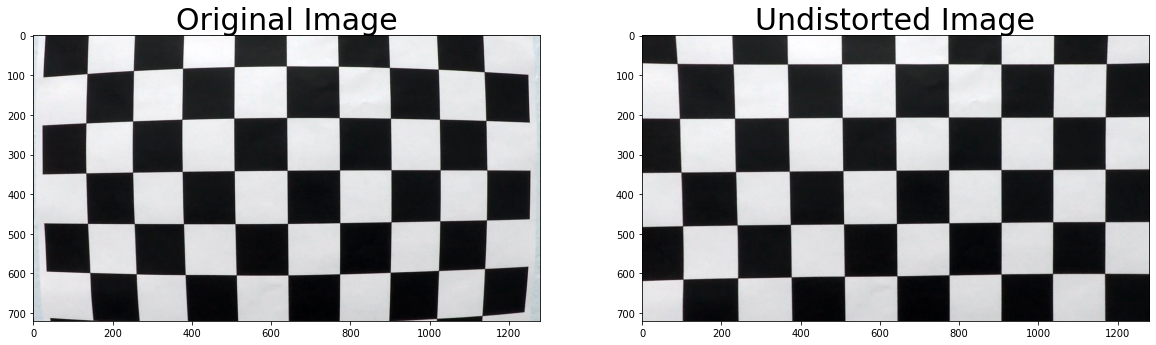

In [42]:
import pickle

# Test undistortion on an image
img = cv2.imread('camera_cal/test_image.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
# Create libary to store all the specs
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
# pickle.dump() is to dump/store/serialize the library dist_pickle = {} to the dest directory 
# so that we could retrieve this library later on OHTER python application.
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_mtx.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
f.savefig('writeup_images/chessboard_undistort_output.jpg')

### 1.3. Image perspective transformation
If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

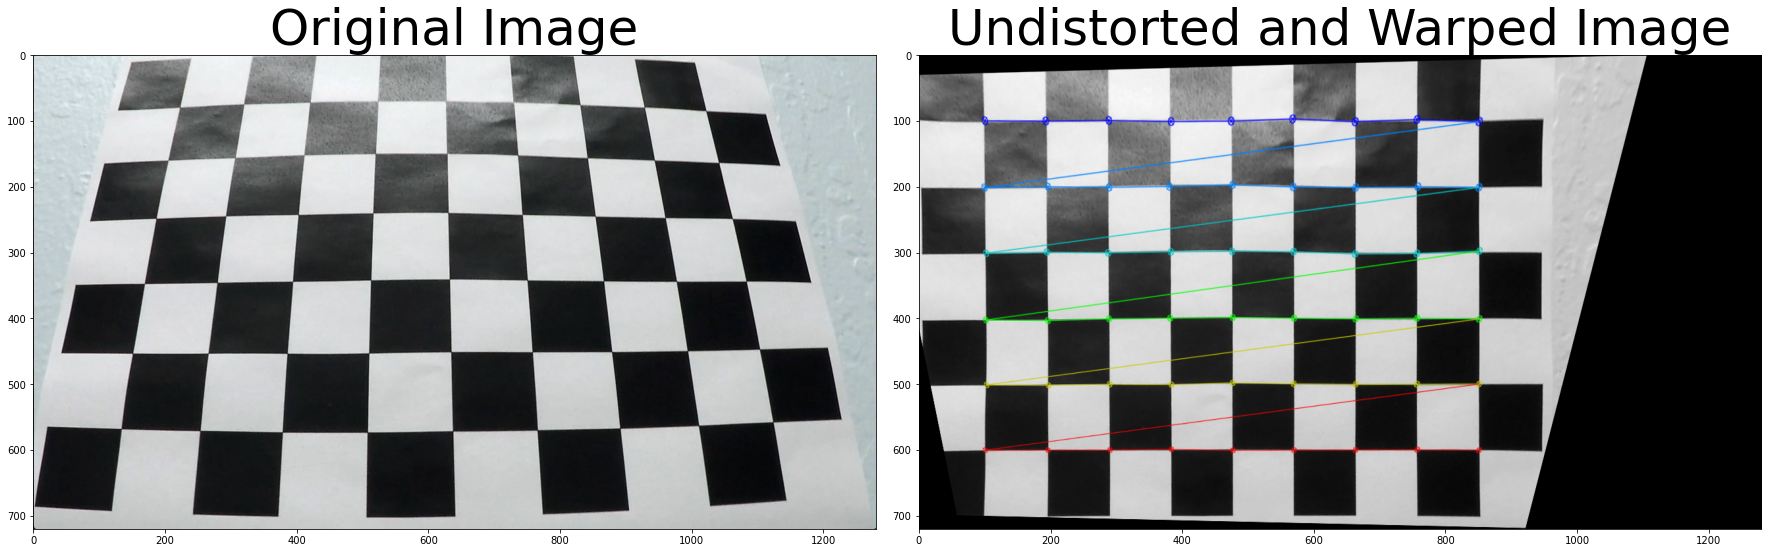

In [52]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/wide_dist_mtx.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('camera_cal/test_image2.jpg')

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 2. Pipeline Single Image

* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### 2.1. Provide an example of a distortion-corrected image.

<img src="./test_images/test1.jpg" width="500">

### 2.2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

<img src="./examples/binary_combo_example.jpg" width="500">

### 2.3.Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 585, 460      | 320, 0        | 
| 203, 720      | 320, 720      |
| 1127, 720     | 960, 720      |
| 695, 460      | 960, 0        |

<img src="./examples/warped_straight_lines.jpg">

### 2.4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Then I did some other stuff and fit my lane lines with a 2nd order polynomial kinda like this:

<img src="./examples/color_fit_lines.jpg" width="500">

### 2.5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

I did this in lines # through # in my code in my_other_file.py


### 2.6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in lines # through # in my code in yet_another_file.py in the function map_lane(). Here is an example of my result on a test image:

<img src="./examples/example_output.jpg" width="500">

## 3. Pipeline Multiple Images

Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

TODO: Build your pipeline that will draw lane lines on the test_images

then save them to the test_images_output directory.

In [3]:
import os
import shutil

# Create output directory
if os.path.exists("test_images_output/"):
    print('Output images will be saved to /test_images_output')
else: 
    print('Directory will be created: /test_images_output')
    os.makedirs("test_images_output/")

directory = os.listdir("test_images/")
    

for filename in directory:
    
    # Copy image to Output Folder
    shutil.copy('test_images/%s'%(filename),'test_images_output/%s'%(filename))
    
    # reading in an image
    image = cv2.imread('test_images/%s'%(filename))
    print('process %s ...'%(filename))

    # printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image) 
    
    ## Musk: Define the vertices of the region of masking
    color_mask = region_of_interest(image, vertices)
    
    #printing the greyscale image
    gray = grayscale(color_mask)
    
    # Define a kernel size for Gaussian smoothing / blurring.
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # Run Canny edge detection
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    # Color Select
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    color_select = np.copy(image)
    # Identify pixels below the threshold, and these that do NOT (below the threshold) will be blacked out.
    thresholds = (color_mask[:,:,0] < rgb_threshold[0]) \
                | (color_mask[:,:,1] < rgb_threshold[1]) \
                | (color_mask[:,:,2] < rgb_threshold[2]) 
    color_select[thresholds] = [0,0,0]
    
    # Hough Transform - Lane Finding
    line_image = hough_lines(edges, rho, theta, threshold, min_line_len, max_line_gap)

    # Remove the line from the Mask
    offset = -10
    vertices_offset = np.array([[[i-offset for i in left_bottom], \
                          [i-offset for i in right_bottom],\
                          [i-offset for i in right_upper],\
                          [i-offset for i in left_upper]]],dtype=np.int32)

    line_image = region_of_interest(line_image, vertices_offset)
    
    # Output the image
    image_out = weighted_img(line_image, image, α=0.8, β=1., γ=0.)
    plt.imshow(image_out)
    cv2.imwrite(os.path.join('test_images_output/%s_out.jpg'%(filename)),image_out)

    
    

Output images will be saved to /test_images_output
process test6.jpg ...
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


NameError: name 'vertices' is not defined

## 4. Pipeline Video

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`project_video.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # printing out some stats and plotting
    # print('This image is:', type(image), 'with dimensions:', image.shape)
    # plt.imshow(image) 
    
    ## Musk: Define the vertices of the region of masking
    color_mask = region_of_interest(image, vertices)
    
    #printing the greyscale image
    gray = grayscale(color_mask)
    
    # Define a kernel size for Gaussian smoothing / blurring.
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # Run Canny edge detection
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    # Color Select
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    color_select = np.copy(image)
    # Identify pixels below the threshold, and these that do NOT (below the threshold) will be blacked out.
    thresholds = (color_mask[:,:,0] < rgb_threshold[0]) \
                | (color_mask[:,:,1] < rgb_threshold[1]) \
                | (color_mask[:,:,2] < rgb_threshold[2]) 
    color_select[thresholds] = [0,0,0]
    
    # Hough Transform - Lane Finding
    line_image = hough_lines(edges, rho, theta, threshold, min_line_len, max_line_gap)

    # Remove the line from the Mask
    offset = -10
    vertices_offset = np.array([[[i-offset for i in left_bottom], \
                          [i-offset for i in right_bottom],\
                          [i-offset for i in right_upper],\
                          [i-offset for i in left_upper]]],dtype=np.int32)

    line_image = region_of_interest(line_image, vertices_offset)
    
    # Output the image
    image_out = weighted_img(line_image, image, α=0.8, β=1., γ=0.)

    return image_out

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/project_video.mp4").subclip(0,5)
## clip1 = VideoFileClip("test_videos/project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))